In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/ML4Health/'

Mounted at /content/drive


# **Load embeddings, build cohort, save data for training**

## Load libraries and setup environment

In [ ]:

!pip install tslearn
!pip install minisom
!pip install dtw-python
!pip install Levenshtein


from tslearn.metrics import cdist_dtw
from sklearn.cluster import AgglomerativeClustering
from minisom import MiniSom
from dtw import dtw

from datetime import timedelta
import os

import numpy as np
import pandas as pd
import seaborn as sns
import os

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

import re
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from IPython.display import display, HTML, Image
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 20})

from google.colab import auth
from google.cloud import bigquery

import bigframes.pandas as bf
import matplotlib.pyplot as plt
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.io as pio
pio.renderers.default = "colab"

from gensim.models import Word2Vec

from IPython.display import clear_output

import torch

import copy
import datetime
import sys




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for minisom: filename=MiniSom-2.3.3-py3-none-any.whl size=11706 sha256=483f38b255e0828977b8543f5267fb673cef1dd410510f01d9bedf8f3c24ec0a
  Stored in directory: /root/.cache/pip/wheels/96/98/a5/52dee3e8ed1dbfc4d77e4da41b6d89dd7ab9ead1b921e766f8
Successfully built minisom
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 764.7/764.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.5 MB/s eta 0:00:00
Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [ ]:
bf.options.bigquery.location = "US"
bf.options.bigquery.project = 'hellobigquery-431508'

# authenticate
auth.authenticate_user()

project_id = 'hellobigquery-431508'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
dataset = 'mimiciv'


## **Load embedding mapping from itemid to vectors**

In [ ]:
# load embedding vectors
df_itemid_to_vector = pd.read_csv(file_path + 'itemid_to_vector.csv')
itemid_to_vector = {str(key): value for key, value in df_itemid_to_vector.set_index('itemid').T.to_dict('list').items()}
print(len(itemid_to_vector))


418


## **Find patients with AD related ICD codes.**

Load all diagnoses icd table, and filter with our event list:

## Possible Tests

## **See what tests are taken by these patients**

For each patient, only keep the test data with charttime before their diagnoses' dischargetime

### **Apply Word2vec embedding, treating each patient's test history as a "sentence" and each labtest as a "word".**

Prepare the sentences:

In [ ]:
query = """
  WITH first_alzheimers_diagnosis AS (
    SELECT
        d.subject_id,
        MIN(a.hadm_id) AS first_hadm_id_with_ad  -- Find the first hospital admission with Alzheimer's ICD codes
    FROM
        physionet-data.mimiciv_hosp.diagnoses_icd AS d
    JOIN
        physionet-data.mimiciv_hosp.admissions AS a
    ON
        d.subject_id = a.subject_id
    WHERE
        d.icd_code IN ('G300', 'G301', 'G308', 'G309')  -- Only include specific Alzheimer's codes
    GROUP BY
        d.subject_id
  )
  SELECT
      filtered.subject_id,
      STRING_AGG(CAST(filtered.itemid AS STRING) ORDER BY filtered.charttime ASC) AS itemid_sequence,  -- ASC for time order
      ARRAY_AGG(CAST(filtered.valuenum AS FLOAT64) ORDER BY filtered.charttime ASC) AS test_value_sequence,  -- ASC for time order
      ARRAY_AGG(CAST(filtered.charttime AS STRING) ORDER BY filtered.charttime ASC) AS test_time_sequence,  -- Added to store charttime
      # ARRAY_AGG(CAST(filtered.hadm_id AS STRING) ORDER BY filtered.charttime ASC) AS test_hadm_sequence,  -- Added to store charttime
      ARRAY_LENGTH(ARRAY_AGG(filtered.itemid ORDER BY filtered.charttime ASC)) AS sequence_length,
      STRING_AGG(DISTINCT filtered.icd_code ORDER BY filtered.icd_code ASC) AS icd_codes,
      'mimic_iv' AS data_source,  -- New column with constant value 'mimic_iv'
      CASE
          WHEN REGEXP_CONTAINS(STRING_AGG(DISTINCT filtered.icd_code ORDER BY filtered.icd_code ASC), r'G30.*')
          OR REGEXP_CONTAINS(STRING_AGG(DISTINCT filtered.icd_code ORDER BY filtered.icd_code ASC), r'331.*')
          THEN 1
          ELSE 0
      END AS label_ad  -- New column that marks Alzheimer's Disease based on G30 ICD codes
  FROM (
      SELECT
          d.subject_id,
          l.itemid,
          l.valuenum,
          l.charttime,
          d.icd_code,
          l.hadm_id,
          ROW_NUMBER() OVER (PARTITION BY d.subject_id, l.itemid ORDER BY l.charttime, l.itemid ASC) AS rn
      FROM
          physionet-data.mimiciv_hosp.diagnoses_icd AS d
      JOIN
          physionet-data.mimiciv_hosp.labevents AS l
      ON
          d.subject_id = l.subject_id
      JOIN
          physionet-data.mimiciv_hosp.admissions AS a
      ON
          l.subject_id = a.subject_id
      JOIN
        physionet-data.mimiciv_hosp.d_labitems AS dlab
      ON
        l.itemid = dlab.itemid
      WHERE
          (
            d.icd_code LIKE 'G30%' OR
            d.icd_code LIKE 'F01%' OR
            d.icd_code LIKE 'F03%' OR
            d.icd_code LIKE 'F02%' OR
            d.icd_code LIKE 'R54%' OR

            d.icd_code IN ('G318', 'G310', 'G311', 'G318', 'G319', '3310', '3311', '3312', '3319', '2904', '2900', '2901', '2902', '2903', '2908', '2909', '797')
          )
          AND l.valuenum IS NOT NULL
          # AND l.charttime <= a.dischtime
          AND l.hadm_id <= a.hadm_id  -- Only include hadm_id before first AD diagnosis
          AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
          AND lower(dlab.fluid) LIKE '%blood%'
  ) AS filtered
  LEFT JOIN
      first_alzheimers_diagnosis AS fad
  ON
      filtered.subject_id = fad.subject_id
  WHERE
      rn <= 2  -- only keep the first two entries for each itemid per patient
      AND (fad.first_hadm_id_with_ad IS NULL OR filtered.hadm_id < fad.first_hadm_id_with_ad)  -- Only include hadm_id before first AD diagnosis
  GROUP BY
      filtered.subject_id
  ORDER BY
      filtered.subject_id;
"""

df_itemid_sequences_4 = bf.read_gbq(query)
print(len(df_itemid_sequences_4))
df_itemid_sequences_4.head(10)


5128


,subject_id,itemid_sequence,test_value_sequence,test_time_sequence,sequence_length,icd_codes,data_source,label_ad
0,10434107,"50804,50804,50808,50808,50821,50821,50818,5081...",[ 3.200e+01 3.200e+01 1.350e+00 1.350e+00 ...,['2162-07-21 00:20:00' '2162-07-21 00:20:00' '...,151,F0390,mimic_iv,0
1,12180905,"50912,51200,51006,50971,50902,50983,51254,5207...",[1.00e+00 2.00e-01 2.30e+01 4.40e+00 1.08e+02 ...,['2171-09-21 22:40:00' '2171-09-21 22:40:00' '...,35,F0390,mimic_iv,0
2,14789992,"51277,51249,52172,51265,51221,51256,51222,5125...",[1.35e+01 3.31e+01 4.68e+01 1.41e+02 4.05e+01 ...,['2167-03-02 05:21:00' '2167-03-02 05:21:00' '...,48,R54,mimic_iv,0
3,10881685,"50998,50998,51222,51222,51275,51275,50952,5095...",[2.99e+02 2.99e+02 8.40e+00 8.40e+00 3.62e+01 ...,['2185-05-06 08:07:00' '2185-05-06 08:07:00' '...,92,2900,mimic_iv,0
4,12702482,"51249,51279,50960,50912,51222,50983,51248,5089...",[3.13e+01 3.42e+00 1.70e+00 7.00e-01 1.05e+01 ...,['2162-11-11 06:00:00' '2162-11-11 06:00:00' '...,75,F0390,mimic_iv,0
5,11476401,"50852,50852,51613,51613,50931,50931,50912,5091...",[ 10.8 10.8 263. 263. 205. 205. 0...,['2175-09-09 05:23:00' '2175-09-09 05:23:00' '...,70,F0390,mimic_iv,0
6,16943681,"51265,51265,51249,51249,51248,51248,51275,5127...",[2.520e+02 2.520e+02 3.410e+01 3.410e+01 3.010...,['2180-08-17 19:14:00' '2180-08-17 19:14:00' '...,128,F0390,mimic_iv,0
7,10727627,"50931,51200,51265,50976,51244,51248,51221,5114...",[1.22e+02 2.00e-01 1.72e+02 6.80e+00 1.52e+01 ...,['2114-07-01 01:09:00' '2114-07-01 01:09:00' '...,85,F0390,mimic_iv,0
8,17798911,"50868,51006,50931,51249,50983,50882,51221,5122...",[1.00e+01 1.50e+01 1.17e+02 3.29e+01 1.43e+02 ...,['2178-06-28 14:20:00' '2178-06-28 14:20:00' '...,92,F0280,mimic_iv,0
9,19427944,"50910,50910,50893,50893,50971,50971,51265,5126...",[ 54. 54. 9. 9. 4.3 4.3 200...,['2165-01-22 21:59:00' '2165-01-22 21:59:00' '...,80,3310,mimic_iv,1


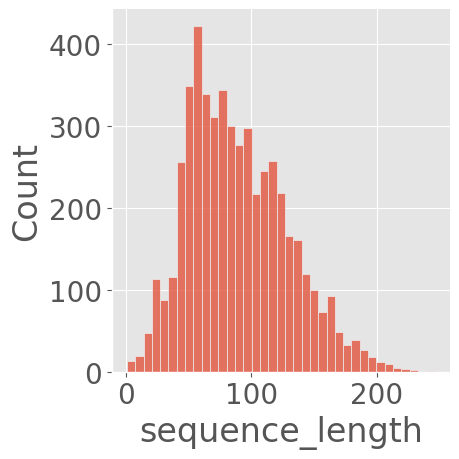

In [ ]:
# prompt: plot distribution of df_itemid_sequences['sequence_length']
df_labtest_sequences_pd_4 = df_itemid_sequences_4.to_pandas()
sns.displot(df_labtest_sequences_pd_4['sequence_length'])


In [ ]:
def calculate_time_difference(time_sequence):
    # Convert the sequence from string to datetime objects
    time_sequence = [datetime.datetime.strptime(t, '%Y-%m-%d %H:%M:%S') for t in time_sequence]

    # Get the last time in the sequence (the reference point)
    last_time = time_sequence[-1]

    # Calculate the difference in days between each time and the last time
    time_diff = [int((last_time - t).total_seconds() / (60 * 60 * 24)) for t in time_sequence]

    return time_diff

# Apply the function to the 'test_time_sequence' column
df_labtest_sequences_pd_4['test_time_sequence'] = df_labtest_sequences_pd_4['test_time_sequence'].apply(lambda x: calculate_time_difference(x))

df_labtest_sequences_pd_4.head()

,subject_id,itemid_sequence,test_value_sequence,test_time_sequence,sequence_length,icd_codes,data_source,label_ad
0,10434107,"50804,50804,50808,50808,50821,50821,50818,5081...",[ 3.200e+01 3.200e+01 1.350e+00 1.350e+00 ...,"[3412, 3412, 3412, 3412, 3412, 3412, 3412, 341...",151,F0390,mimic_iv,0
1,12180905,"50912,51200,51006,50971,50902,50983,51254,5207...",[1.00e+00 2.00e-01 2.30e+01 4.40e+00 1.08e+02 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,F0390,mimic_iv,0
2,14789992,"51277,51249,52172,51265,51221,51256,51222,5125...",[1.35e+01 3.31e+01 4.68e+01 1.41e+02 4.05e+01 ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",48,R54,mimic_iv,0
3,10881685,"50998,50998,51222,51222,51275,51275,50952,5095...",[2.99e+02 2.99e+02 8.40e+00 8.40e+00 3.62e+01 ...,"[638, 638, 638, 638, 638, 638, 638, 638, 638, ...",92,2900,mimic_iv,0
4,12702482,"51249,51279,50960,50912,51222,50983,51248,5089...",[3.13e+01 3.42e+00 1.70e+00 7.00e-01 1.05e+01 ...,"[839, 839, 839, 839, 839, 839, 839, 839, 839, ...",75,F0390,mimic_iv,0


In [ ]:
print(df_labtest_sequences_pd_4['sequence_length'].max())
print(df_labtest_sequences_pd_4['sequence_length'].min())

246
1


In [ ]:
print(df_labtest_sequences_pd_4.dtypes)

subject_id                                   Int64
itemid_sequence                    string[pyarrow]
test_value_sequence    list<item: double>[pyarrow]
test_time_sequence                          object
sequence_length                              Int64
icd_codes                          string[pyarrow]
data_source                        string[pyarrow]
label_ad                                     Int64
dtype: object


### **Similarly for MIMIC_III**

In [ ]:
query = """
  SELECT
    subject_id,
    STRING_AGG(CAST(itemid AS STRING) ORDER BY charttime ASC) AS itemid_sequence,  -- ASC for time order
    ARRAY_AGG(CAST(valuenum AS FLOAT64) ORDER BY charttime ASC) AS test_value_sequence,  -- ASC for time order
    ARRAY_AGG(CAST(charttime AS STRING) ORDER BY charttime ASC) AS test_time_sequence,  -- Added to store charttime
    # ARRAY_AGG(CAST(hadm_id AS STRING) ORDER BY charttime ASC) AS test_hadm_sequence,  -- Added to store hadm
    ARRAY_LENGTH(ARRAY_AGG(itemid ORDER BY charttime ASC)) AS sequence_length,
    STRING_AGG(DISTINCT icd9_code ORDER BY icd9_code ASC) AS icd_codes,
    'mimic_iii' AS data_source,
    CASE WHEN STRING_AGG(DISTINCT icd9_code ORDER BY icd9_code ASC) LIKE '331%' THEN 1 ELSE 0 END AS label_ad
  FROM (
    SELECT
      d.subject_id,
      l.itemid,
      l.valuenum,
      l.charttime,
      l.hadm_id,
      d.icd9_code,
      ROW_NUMBER() OVER (PARTITION BY d.subject_id, l.itemid ORDER BY l.charttime ASC) AS rn
    FROM
        `physionet-data.mimiciii_clinical.diagnoses_icd` AS d
    JOIN
        `physionet-data.mimiciii_clinical.labevents` AS l
    ON
        d.subject_id = l.subject_id
    JOIN
        `physionet-data.mimiciii_clinical.admissions` AS a
    ON
        l.subject_id = a.subject_id
    INNER JOIN
      `physionet-data.mimiciii_clinical.d_labitems` AS dlab
    ON
      l.itemid = dlab.itemid
    WHERE
      d.icd9_code LIKE '331%'  -- ICD-9 codes for Alzheimer's and related diseases
      AND l.valuenum IS NOT NULL
      AND l.hadm_id <= a.hadm_id  -- Only include hadm_id before first AD diagnosis
      AND (LOWER(l.flag) LIKE 'abnormal%' OR l.flag IS NULL)
      AND lower(dlab.fluid) LIKE '%blood%'
      -- AND dlab.itemid NOT IN (50912, 50971, 51006, 50983, 50902, 50882, 50868, 50931, 51221, 51265,
      --  51222, 51301, 51279, 51250, 51277, 51248, 51249, 50960, 50893, 50970,
      --  51274, 51237, 51275, 52172, 50947, 50934, 51678, 50878, 51491, 50863,
      --  50885, 50861, 51498, 51200, 51244, 51256, 51254, 51146)
  ) AS filtered
  WHERE
    rn <= 2  -- only keep the first two entries for each itemid per patient
  GROUP BY
    subject_id
  ORDER BY
    subject_id;
"""


df_itemid_sequences_3 = bf.read_gbq(query)
print(len(df_itemid_sequences_3))
df_itemid_sequences_3.head(10)

1246


,subject_id,itemid_sequence,test_value_sequence,test_time_sequence,sequence_length,icd_codes,data_source,label_ad
0,20026,"51256,50902,50882,50893,50862,51222,50971,5098...",[8.66e+01 9.90e+01 2.60e+01 8.90e+00 3.40e+00 ...,['2197-04-10 08:30:00' '2197-04-10 08:30:00' '...,55,3310,mimic_iii,1
1,10774,"50817,50817,50811,50811,50810,50810,51279,5127...",[6.50e+01 6.50e+01 1.14e+01 1.14e+01 3.40e+01 ...,['2136-10-09 13:44:00' '2136-10-09 13:44:00' '...,148,3310,mimic_iii,1
2,6389,"51249,51244,51146,51006,51221,51254,50882,5124...",[3.48e+01 2.85e+01 2.00e-01 1.00e+01 3.79e+01 ...,['2147-07-25 02:45:00' '2147-07-25 02:45:00' '...,57,3314,mimic_iii,1
3,56257,"51006,51249,51265,51301,51274,50931,50960,5123...",[ 15. 33.9 294. 12.4 12.6 150. 1...,['2198-06-26 14:15:00' '2198-06-26 14:15:00' '...,53,33182,mimic_iii,1
4,31755,"50803,50803,50806,50806,50808,50808,50813,5081...",[ 2.400e+01 2.400e+01 9.400e+01 9.400e+01 ...,['2169-10-25 04:12:00' '2169-10-25 04:12:00' '...,172,3310,mimic_iii,1
5,26252,"51237,51244,50902,51006,51221,51248,51200,5125...",[ 1.1 11.4 101. 12. 45. 22.7 0...,['2170-07-14 17:40:00' '2170-07-14 17:40:00' '...,63,3314,mimic_iii,1
6,32592,"51237,51237,51301,51301,51214,51214,51221,5122...",[1.000e+00 1.000e+00 1.100e+01 1.100e+01 2.780...,['2137-08-17 23:40:00' '2137-08-17 23:40:00' '...,126,3310,mimic_iii,1
7,50208,"51248,50931,51301,50956,51249,51275,51277,5122...",[3.13e+01 1.63e+02 1.03e+01 3.80e+01 3.28e+01 ...,['2200-07-30 18:55:00' '2200-07-30 18:55:00' '...,113,3314,mimic_iii,1
8,10640,"50882,50970,50931,51237,51249,51279,50902,5120...",[2.50e+01 3.70e+00 1.65e+02 1.00e+00 3.54e+01 ...,['2125-09-04 07:00:00' '2125-09-04 07:00:00' '...,27,3314,mimic_iii,1
9,97542,"50971,50983,50868,51274,51301,51221,51250,5093...",[ 3.50e+00 1.40e+02 1.90e+01 1.38e+01 1.49...,['2165-06-03 21:38:00' '2165-06-03 21:38:00' '...,105,3314,mimic_iii,1


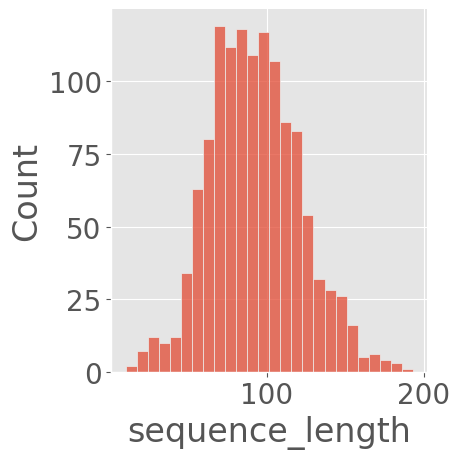

In [ ]:
df_labtest_sequences_pd_3 = df_itemid_sequences_3.to_pandas()
sns.displot(df_labtest_sequences_pd_3['sequence_length'])

In [ ]:
df_labtest_sequences_pd_3['test_time_sequence'] = df_labtest_sequences_pd_3['test_time_sequence'].apply(lambda x: calculate_time_difference(x))

df_labtest_sequences_pd_3

,subject_id,itemid_sequence,test_value_sequence,test_time_sequence,sequence_length,icd_codes,data_source,label_ad
0,20026,"51256,50902,50882,50893,50862,51222,50971,5098...",[8.66e+01 9.90e+01 2.60e+01 8.90e+00 3.40e+00 ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",55,3310,mimic_iii,1
1,10774,"50817,50817,50811,50811,50810,50810,51279,5127...",[6.50e+01 6.50e+01 1.14e+01 1.14e+01 3.40e+01 ...,"[1635, 1635, 1635, 1635, 1635, 1635, 1635, 163...",148,3310,mimic_iii,1
2,6389,"51249,51244,51146,51006,51221,51254,50882,5124...",[3.48e+01 2.85e+01 2.00e-01 1.00e+01 3.79e+01 ...,"[7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, ...",57,3314,mimic_iii,1
3,56257,"51006,51249,51265,51301,51274,50931,50960,5123...",[ 15. 33.9 294. 12.4 12.6 150. 1...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",53,33182,mimic_iii,1
4,31755,"50803,50803,50806,50806,50808,50808,50813,5081...",[ 2.400e+01 2.400e+01 9.400e+01 9.400e+01 ...,"[40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 4...",172,3310,mimic_iii,1
...,...,...,...,...,...,...,...,...
1241,76896,"51200,51265,50971,51248,51274,50902,51244,5127...",[1.10e+00 1.29e+02 3.90e+00 3.31e+01 1.19e+01 ...,"[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...",109,3314,mimic_iii,1
1242,96333,"51265,51200,51222,50912,51301,51250,51274,5127...",[1.44e+02 1.00e+00 1.17e+01 7.00e-01 9.80e+00 ...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",111,3314,mimic_iii,1
1243,9142,"50882,51200,51275,51249,50971,51250,50861,5124...",[ 21. 4.4 26.1 33.6 4.7 92. 22...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",91,3314,mimic_iii,1
1244,8709,"51279,51250,51249,51244,50868,50885,51006,5098...",[ 2.730e+00 9.400e+01 3.330e+01 6.700e+00 ...,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",115,3310,mimic_iii,1


**Combine data fromo mimic iii and iv**

Skewness: 0.49491873329542


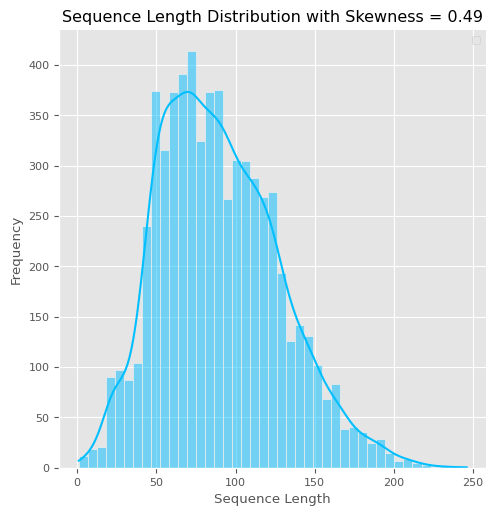

In [ ]:
# df_labtest_sequences_pd = df_itemid_sequences.to_pandas()
df_labtest_sequences_pd = pd.concat([df_labtest_sequences_pd_4, df_labtest_sequences_pd_3], ignore_index=True)

import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

plt.rcParams.update({'font.size': 8})

sns.displot(df_labtest_sequences_pd['sequence_length'], kde=True, color='#00BFFF')

skewness = df_labtest_sequences_pd['sequence_length'].skew()
print(f'Skewness: {skewness}')

plt.title(f'Sequence Length Distribution with Skewness = {skewness:.2f}')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [ ]:
# for i in range(len(df_labtest_sequences_pd)):
#   seq = df_labtest_sequences_pd.loc[i, 'itemid_sequence']
#   if '52285' in seq:
#     print(seq)

**Split itemid sequences, save dataframe**

In [ ]:
import ast
from math import log

df_labtest_sequences_pd['days_to_diag_sequence'] = df_labtest_sequences_pd['test_time_sequence']
df_labtest_sequences_pd['test_time_sequence'] = df_labtest_sequences_pd['test_time_sequence'].apply(lambda x: [log(item+2) for item in x])  # log only positive values
df_labtest_sequences_pd['itemid_sequence'] = df_labtest_sequences_pd['itemid_sequence'].apply(lambda x: x.split(',') if isinstance(x, str) else [])
# df_labtest_sequences_pd['test_value_sequence'] = df_labtest_sequences_pd['test_value_sequence'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])
# df_labtest_sequences_pd.to_csv(file_path + 'df_labtest_sequences_pd.csv', index=False)

# =============== Decreasing order - Days to diagnosis
def generate_hadm_rev(sequence):
    hadm_rev = []
    unique_seen = set()
    for value in reversed(sequence):
        unique_seen.add(value)
        hadm_rev.append(len(unique_seen) - 1)
    return list(reversed(hadm_rev))

# ================ Increasing order
# def generate_hadm_rev(sequence):
#     hadm_rev = []
#     unique_seen = set()
#     count = 0
#     for value in sequence:
#         if value not in unique_seen:
#             count += 1
#             unique_seen.add(value)
#         hadm_rev.append(count)
#     return hadm_rev

# df_labtest_sequences_pd['hadm_rev'] = df_labtest_sequences_pd['test_time_sequence'].apply(generate_hadm_rev)


# df_labtest_sequences_pd = df_labtest_sequences_pd.drop_duplicates(subset=['subject_id']).reset_index(drop=True)

# patients_itemid_seqs = df_labtest_sequences_pd['itemid_sequence']
# patients_itemid_seqs[:1]
df_labtest_sequences_pd

,subject_id,itemid_sequence,test_value_sequence,test_time_sequence,sequence_length,icd_codes,data_source,label_ad,days_to_diag_sequence
0,10434107,"[50804, 50804, 50808, 50808, 50821, 50821, 508...",[ 3.200e+01 3.200e+01 1.350e+00 1.350e+00 ...,"[8.135639903354386, 8.135639903354386, 8.13563...",151,F0390,mimic_iv,0,"[3412, 3412, 3412, 3412, 3412, 3412, 3412, 341..."
1,12180905,"[50912, 51200, 51006, 50971, 50902, 50983, 512...",[1.00e+00 2.00e-01 2.30e+01 4.40e+00 1.08e+02 ...,"[0.6931471805599453, 0.6931471805599453, 0.693...",35,F0390,mimic_iv,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,14789992,"[51277, 51249, 52172, 51265, 51221, 51256, 512...",[1.35e+01 3.31e+01 4.68e+01 1.41e+02 4.05e+01 ...,"[1.0986122886681098, 1.0986122886681098, 1.098...",48,R54,mimic_iv,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,10881685,"[50998, 50998, 51222, 51222, 51275, 51275, 509...",[2.99e+02 2.99e+02 8.40e+00 8.40e+00 3.62e+01 ...,"[6.461468176353717, 6.461468176353717, 6.46146...",92,2900,mimic_iv,0,"[638, 638, 638, 638, 638, 638, 638, 638, 638, ..."
4,12702482,"[51249, 51279, 50960, 50912, 51222, 50983, 512...",[3.13e+01 3.42e+00 1.70e+00 7.00e-01 1.05e+01 ...,"[6.734591659972948, 6.734591659972948, 6.73459...",75,F0390,mimic_iv,0,"[839, 839, 839, 839, 839, 839, 839, 839, 839, ..."
...,...,...,...,...,...,...,...,...,...
6369,76896,"[51200, 51265, 50971, 51248, 51274, 50902, 512...",[1.10e+00 1.29e+02 3.90e+00 3.31e+01 1.19e+01 ...,"[3.091042453358316, 3.091042453358316, 3.09104...",109,3314,mimic_iii,1,"[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2..."
6370,96333,"[51265, 51200, 51222, 50912, 51301, 51250, 512...",[1.44e+02 1.00e+00 1.17e+01 7.00e-01 9.80e+00 ...,"[1.3862943611198906, 1.3862943611198906, 1.386...",111,3314,mimic_iii,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."
6371,9142,"[50882, 51200, 51275, 51249, 50971, 51250, 508...",[ 21. 4.4 26.1 33.6 4.7 92. 22...,"[0.6931471805599453, 0.6931471805599453, 0.693...",91,3314,mimic_iii,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6372,8709,"[51279, 51250, 51249, 51244, 50868, 50885, 510...",[ 2.730e+00 9.400e+01 3.330e+01 6.700e+00 ...,"[1.3862943611198906, 1.3862943611198906, 1.386...",115,3310,mimic_iii,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ..."


In [ ]:
# df_labtest_sequences_pd = pd.read_csv('df_labtest_sequences_pd.csv')
print(len(df_labtest_sequences_pd))
df_labtest_sequences_pd.head(1)

6374


,subject_id,itemid_sequence,test_value_sequence,test_time_sequence,sequence_length,icd_codes,data_source,label_ad,days_to_diag_sequence
0,10434107,"[50804, 50804, 50808, 50808, 50821, 50821, 508...",[ 3.200e+01 3.200e+01 1.350e+00 1.350e+00 ...,"[8.135639903354386, 8.135639903354386, 8.13563...",151,F0390,mimic_iv,0,"[3412, 3412, 3412, 3412, 3412, 3412, 3412, 341..."


In [ ]:
df_labtest_sequences_pd.dtypes

,0
subject_id,Int64
itemid_sequence,object
test_value_sequence,list<item: double>[pyarrow]
test_time_sequence,object
sequence_length,Int64
icd_codes,string[pyarrow]
data_source,string[pyarrow]
label_ad,Int64
days_to_diag_sequence,object


# **Apply scalers for each labtest**

**Train scalers for each labtest itemid based on global data**

In [ ]:
# from sklearn.preprocessing import RobustScaler

# labtest_scalers = {}
# outlier_ranges = []

# unique_itemids = df_ad_patients_lab_results_pd['itemid'].unique()
# num_itemids = len(unique_itemids)

# for i in range(num_itemids):
#   itemid = unique_itemids[i]

#   item_values = df_ad_patients_lab_results_pd[df_ad_patients_lab_results_pd['itemid'] == itemid]['valuenum'].dropna()
#   # print(f"Processing Itemid: {itemid}, values: {item_values}")

#   if item_values.empty:
#     print(f"Itemid: {itemid} has no valid data, skipping.")
#     continue


#   if item_values.size == 0:
#     print(f"Itemid: {itemid} has no valid data, skipping.")
#     continue

#   sys.stdout.write(f"\rProcessing itemid {itemid} , {i + 1}/{num_itemids} ({(i + 1) / num_itemids * 100:.2f}%)")
#   sys.stdout.flush()

#   item_values_array = item_values.values.reshape(-1, 1)


#   scaler = RobustScaler()
#   scaler.fit(item_values_array)

#   labtest_scalers[itemid] = scaler



In [ ]:
# print(len(labtest_scalers))
# print(labtest_scalers)

**save scaler**

In [ ]:
# import pickle

# with open(file_path + 'labtest_scalers.pkl', 'wb') as file:
#     pickle.dump(labtest_scalers, file)

**Concatenate vectors of patients to matrices**


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict
import sys

df_all = copy.deepcopy(df_labtest_sequences_pd)

# df_all['itemid_sequence'] = df_all['itemid_sequence'].apply(lambda x: list(x) if isinstance(x, list) else x)
df_all['test_value_sequence'] = df_all['test_value_sequence'].apply(lambda x: list(x) if isinstance(x, list) else x)


df_all['matrix'] = None
df_all['scaled_value_sequence'] = None

missing_scaler_count = defaultdict(int)
missing_pca_vector_count = defaultdict(int)
outlier_count = defaultdict(int)

num_patients = len(df_all)

for i in range(len(df_all)):

  patient_matrix = []
  updated_itemid_sequence = []
  updated_test_value_sequence = []
  scaled_values = []

  sys.stdout.write(f"\rProcessing patient {i + 1}/{num_patients} ({(i + 1) / num_patients * 100:.2f}%)")
  sys.stdout.flush()

  itemid_sequence = df_all.loc[i, 'itemid_sequence']
  test_value_sequence = df_all.loc[i, 'test_value_sequence']
  test_time_sequence = df_all.loc[i, 'test_time_sequence']
  test_days_sequence = df_all.loc[i, 'days_to_diag_sequence']
  # print(itemid_sequence)
  # print(test_value_sequence)

  # iterate through itemid and test_value
  for itemid, test_value, delta_time in zip(itemid_sequence, test_value_sequence, test_time_sequence):
    # if itemid == '52285':
    #   print(itemid, test_value)
    #
    # print(itemid, test_value)
    # scaler = labtest_scalers.get(itemid)
    # if scaler is None:
    #     missing_scaler_count[itemid] += 1
    #     continue  # Skip if no scaler for the itemid

    # item_range = df_outlier_ranges[df_outlier_ranges['itemid'] == itemid]
    # # print(item_range)
    # lower_bound = item_range['lower_bound'].values[0] if not item_range.empty else None
    # upper_bound = item_range['upper_bound'].values[0] if not item_range.empty else None

    # if lower_bound is not None and upper_bound is not None:
    #     if test_value < lower_bound or test_value > upper_bound:
    #         outlier_count[itemid] += 1
    #         continue  # Skip if the test value is outside the outlier range
    # else:
    #     print(f"No outlier range found for itemid: {itemid}")
    #     continue


    pca_vector = itemid_to_vector.get(str(itemid))
    if pca_vector is None:
        missing_pca_vector_count[itemid] += 1
        continue  # Skip if no PCA vector for the itemid

    # combine the 20-dim PCA vector with the test value to form a 21-dim vector
    test_value_array = np.array(test_value).reshape(-1, 1)
    test_time_array = np.array(delta_time).reshape(-1, 1)
    # test_hadm_array = np.array(hadm).reshape(-1, 1)

    # test_value_scaled = scaler.transform(test_value_array)
    # print(test_value, test_value_scaled)

    # combined_vector = np.append(pca_vector, test_value_scaled)
    combined_vector = np.append(pca_vector, test_value)
    combined_vector = np.append(combined_vector, delta_time)
    # combined_vector = np.append(combined_vector, hadm)
    if len(combined_vector) != 22:
      print(itemid, len(combined_vector))

    patient_matrix.append(combined_vector)
    # print(combined_vector)

    # Update sequences
    updated_itemid_sequence.append(itemid)
    updated_test_value_sequence.append(test_value)
    # scaled_values.append(test_value_scaled.item())

  # update the patient's matrix and sequences in df
  df_all.at[i, 'matrix'] = patient_matrix
  df_all.at[i, 'itemid_sequence'] = updated_itemid_sequence
  df_all.at[i, 'test_value_sequence'] = updated_test_value_sequence
  df_all.at[i, 'sequence_length'] = len(updated_itemid_sequence)
  # df_all.at[i, 'scaled_value_sequence'] = scaled_values

print('\n')
print(df_all.head(1))
print(f"Number of patients: {len(df_all)}")
# print(f"Number of values with missing scaler: {missing_scaler_count}")
print(f"Number of values with missing pca vector: {missing_pca_vector_count}")
print(f"Number of values outside outlier range: {outlier_count}")

df_all = df_all[df_all['sequence_length'] >= 4].reset_index(drop=True)
df_all.head(5)


Processing patient 6374/6374 (100.00%)

   subject_id                                    itemid_sequence  \
0    10434107  [50804, 50804, 50808, 50808, 50821, 50821, 508...   

                                 test_value_sequence  \
0  [32.0, 32.0, 1.35, 1.35, 183.0, 183.0, 84.0, 8...   

                                  test_time_sequence  sequence_length  \
0  [8.135639903354386, 8.135639903354386, 8.13563...              151   

  icd_codes data_source  label_ad  \
0     F0390    mimic_iv         0   

                               days_to_diag_sequence  \
0  [3412, 3412, 3412, 3412, 3412, 3412, 3412, 341...   

                                              matrix scaled_value_sequence  
0  [[-0.98442346, 0.8614824, 0.17701308, 0.076649...                  None  
Number of patients: 6374
Number of values with missing pca vector: defaultdict(<class 'int'>, {'51579': 1, '50898': 20, '51203': 5, '51209': 2, '51210': 2, '51208': 12, '51202': 10, '51772': 2, '51767': 2, '51765': 2, '52

,subject_id,itemid_sequence,test_value_sequence,test_time_sequence,sequence_length,icd_codes,data_source,label_ad,days_to_diag_sequence,matrix,scaled_value_sequence
0,10434107,"[50804, 50804, 50808, 50808, 50821, 50821, 508...","[32.0, 32.0, 1.35, 1.35, 183.0, 183.0, 84.0, 8...","[8.135639903354386, 8.135639903354386, 8.13563...",151,F0390,mimic_iv,0,"[3412, 3412, 3412, 3412, 3412, 3412, 3412, 341...","[[-0.98442346, 0.8614824, 0.17701308, 0.076649...",None
1,12180905,"[50912, 51200, 51006, 50971, 50902, 50983, 512...","[1.0, 0.2, 23.0, 4.4, 108.0, 145.0, 9.5, 0.02,...","[0.6931471805599453, 0.6931471805599453, 0.693...",35,F0390,mimic_iv,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[-1.4755245, 0.6031277, 0.70336694, 0.7012964...",None
2,14789992,"[51277, 51249, 52172, 51265, 51221, 51256, 512...","[13.5, 33.1, 46.8, 141.0, 40.5, 69.5, 13.4, 95...","[1.0986122886681098, 1.0986122886681098, 1.098...",48,R54,mimic_iv,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[[-1.6089201, 0.5409125, 0.9043556, 0.5779545,...",None
3,10881685,"[50998, 50998, 51222, 51222, 51275, 51275, 509...","[299.0, 299.0, 8.4, 8.4, 36.2, 36.2, 12.0, 12....","[6.461468176353717, 6.461468176353717, 6.46146...",92,2900,mimic_iv,0,"[638, 638, 638, 638, 638, 638, 638, 638, 638, ...","[[-0.5170381, -0.36540443, 0.13875696, -0.6136...",None
4,12702482,"[51249, 51279, 50960, 50912, 51222, 50983, 512...","[31.3, 3.42, 1.7, 0.7, 10.5, 140.0, 30.7, 9.0,...","[6.734591659972948, 6.734591659972948, 6.73459...",75,F0390,mimic_iv,0,"[839, 839, 839, 839, 839, 839, 839, 839, 839, ...","[[-1.3944707, 0.43157575, 0.68687207, 0.584786...",None


In [ ]:
df_all['label'] = df_all['label_ad'].apply(lambda x: True if x == 1 else False)

# Filter valid sequences
# df_all = df_all[df_all['test_time_sequence'].apply(lambda x: len(x) > 3 and x[0] >= 1)]
df_all = df_all[df_all['test_time_sequence'].apply(lambda x: len(x) > 3)]


df_all = df_all.reset_index(drop=True)
print(f"Number of patients after filtering: {len(df_all)}")

Number of patients after filtering: 6369


**save matrix df** (not fixed yet)

In [ ]:
# df_all['matrix'] = df_all['matrix'].apply(lambda x: str(x))
# df_all.to_csv(file_path + 'df_blood_time.csv', index=False)
# np.save(file_path + 'matrix_data_diag_time.npy', df_all['matrix'].values)

In [ ]:
# df_all = pd.read_csv(file_path + 'df_labtest_sequences_pd_pre_blood.csv')
# df_all['matrix'] = df_all['matrix'].apply(lambda x: np.array(eval(x, {'array': np.array})))


In [ ]:

# df_labtest_sequences_pd = copy.deepcopy(df_all)
# df_all.head(1)

In [ ]:
def filter_matrix_by_days(matrix, days_to_diag_sequence, days_keep):
  matrix = np.array(matrix)
  keep_rows = sum(1 for x in days_to_diag_sequence if x >= days_keep)
  if keep_rows == 0:
      return None
  return matrix[:keep_rows, :], days_to_diag_sequence[keep_rows-1]


## **Further pre-process data**


In [ ]:
checkpoint_dir = file_path + '/model_checkpoints/hadm_delta'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
random_seed = 42
df_model_pd = copy.deepcopy(df_all)

## ======================== IMPORTANT HERE
days_keep = 365
## ============================================

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import os



# data distribution
print("Initial Distribution of Labels (True for Alzheimer's, False for Other):")
print(df_model_pd['label'].value_counts())

# df_model_pd['filtered_matrix'] = df_model_pd.apply(lambda row: filter_matrix_by_hadm_rev(row['matrix'], row['hadm_rev'], hadm_keep), axis=1)
df_model_pd[['filtered_matrix', 'last_time']] = df_model_pd.apply(
    lambda row: pd.Series(filter_matrix_by_days(row['matrix'], row['days_to_diag_sequence'], days_keep)),
    axis=1
)
df_model_pd = df_model_pd.dropna(subset=['filtered_matrix']).reset_index(drop=True)

# df_model_pd = df_model_pd[
#     (df_model_pd['sequence_length'] >= 4)
# ]

train_df_filtered, eval_df_filtered = train_test_split(df_model_pd, test_size=0.1, random_state=random_seed, stratify=df_model_pd['label'])
# split dataset
# train_df, eval_df = train_test_split(df_model_pd, test_size=0.1, random_state=random_seed, stratify=df_model_pd['label'])
# train_df['filtered_matrix'] = train_df.apply(lambda row: filter_matrix_by_hadm_rev(row['matrix'], row['hadm_rev'], hadm_keep), axis=1)
# eval_df['filtered_matrix'] = eval_df.apply(lambda row: filter_matrix_by_hadm_rev(row['matrix'], row['hadm_rev'], hadm_keep), axis=1)

# train_df_filtered = train_df.dropna(subset=['filtered_matrix']).reset_index(drop=True)
# eval_df_filtered = eval_df.dropna(subset=['filtered_matrix']).reset_index(drop=True)

# set all itemid
all_itemids = set()
df_model_pd['itemid_sequence'].apply(lambda x: all_itemids.update(x))

# get average of last test time
average_last_test_time = df_model_pd['last_time'].mean()
min_last_test_time = df_model_pd['last_time'].min()
q1_last_test_time = df_model_pd['last_time'].quantile(0.25)
median_last_test_time = df_model_pd['last_time'].median()
q3_last_test_time = df_model_pd['last_time'].quantile(0.75)
max_last_test_time = df_model_pd['last_time'].max()

print("All unique itemids:", all_itemids)
print("Average of last values in test_time_sequence:", average_last_test_time)



# resample True
true_train_df = train_df_filtered[train_df_filtered['label'] == True]
duplicated_true_train_df = pd.concat([true_train_df] * 1)  # change number for re-sampling

# downsample False
false_train_df = train_df_filtered[train_df_filtered['label'] == False]

# filtered_false_train_df = false_train_df[
#     (false_train_df['sequence_length'] >= 4)
# ]
filtered_false_train_df = false_train_df

# ================================ Change sampling fraction
downsampled_false_train_df = filtered_false_train_df.sample(frac=0.33, random_state=random_seed)

# combine
train_df = pd.concat([duplicated_true_train_df, downsampled_false_train_df])

print("Resampled Distribution of Labels (True for Alzheimer's, False for Other):")
print(train_df['label'].value_counts())

# matrix to PyTorch tensors
X_train_tensor = [torch.tensor(matrix, dtype=torch.float32) for matrix in train_df['filtered_matrix']]
y_train_tensor = torch.tensor(train_df['label'].astype(int).values, dtype=torch.long)

# =============================================================
# eval dataset
true_eval_df = eval_df_filtered[eval_df_filtered['label'] == True]
false_eval_df = eval_df_filtered[eval_df_filtered['label'] == False]
n_true_samples = len(true_eval_df)
n_false_samples = len(false_eval_df)

if n_false_samples < n_true_samples:
    downsampled_false_eval_df = false_eval_df.sample(n=n_true_samples, replace=True, random_state=random_seed)
else:
    downsampled_false_eval_df = false_eval_df.sample(n=n_true_samples, replace=False, random_state=random_seed)


eval_df = pd.concat([true_eval_df, downsampled_false_eval_df])

X_eval_tensor = [torch.tensor(matrix, dtype=torch.float32) for matrix in eval_df['filtered_matrix']]
y_eval_tensor = torch.tensor(eval_df['label'].astype(int).values, dtype=torch.long)

print("Resampled Evaluation Distribution of Labels (True for Alzheimer's, False for Other):")
print(eval_df['label'].value_counts())

# df_model_pd


Initial Distribution of Labels (True for Alzheimer's, False for Other):
label
False    3580
True     2789
Name: count, dtype: int64
All unique itemids: {'51250', '51768', '50869', '50889', '50819', '51248', '50926', '51200', '51228', '52108', '50878', '51271', '51651', '51237', '51283', '50801', '51265', '50823', '51204', '51232', '51616', '51657', '51277', '51284', '50995', '50885', '51148', '51298', '51244', '50900', '50978', '51229', '50988', '51736', '50810', '51689', '51226', '51297', '51263', '51176', '50861', '51185', '50868', '50947', '51652', '50811', '50864', '51214', '50881', '51138', '51567', '51000', '51245', '50903', '50908', '51222', '51140', '51626', '51658', '50805', '51225', '50976', '51667', '51737', '51662', '50820', '52172', '51300', '51259', '50953', '50960', '50813', '50902', '51224', '50974', '50981', '51223', '50853', '50924', '50980', '51763', '51174', '51205', '50852', '51279', '51613', '51175', '52107', '50911', '50822', '50817', '51282', '51251', '50929', '

In [ ]:
# download df_model_pd to excel to local

# from google.colab import files
# df_model_pd.to_excel('df_model_pd.xlsx', index=False)
# files.download('df_model_pd.xlsx')

In [ ]:

# X_train_tensor = [torch.tensor(matrix, dtype=torch.float32)[:, :21] for matrix in train_df['filtered_matrix']]
# X_eval_tensor = [torch.tensor(matrix, dtype=torch.float32)[:, :21] for matrix in eval_df['filtered_matrix']]


## **Apply LSTM**

Epoch [1/200], Train Loss: 0.7239, Eval Loss: 0.6925, Train Acc: 0.4840, Eval Acc: 0.5000
Epoch [2/200], Train Loss: 0.7173, Eval Loss: 0.6908, Train Acc: 0.5032, Eval Acc: 0.5926
Epoch [3/200], Train Loss: 0.7133, Eval Loss: 0.6901, Train Acc: 0.5224, Eval Acc: 0.5093
Epoch [4/200], Train Loss: 0.7141, Eval Loss: 0.6898, Train Acc: 0.5246, Eval Acc: 0.5278
Epoch [5/200], Train Loss: 0.7105, Eval Loss: 0.6888, Train Acc: 0.5684, Eval Acc: 0.5370
Epoch [6/200], Train Loss: 0.7112, Eval Loss: 0.6881, Train Acc: 0.5609, Eval Acc: 0.5278
Epoch [7/200], Train Loss: 0.7094, Eval Loss: 0.6864, Train Acc: 0.5769, Eval Acc: 0.5463
Epoch [8/200], Train Loss: 0.7096, Eval Loss: 0.6852, Train Acc: 0.5630, Eval Acc: 0.5556
Epoch [9/200], Train Loss: 0.7113, Eval Loss: 0.6835, Train Acc: 0.5588, Eval Acc: 0.5556
Epoch [10/200], Train Loss: 0.7086, Eval Loss: 0.6822, Train Acc: 0.5513, Eval Acc: 0.5556
Epoch [11/200], Train Loss: 0.7054, Eval Loss: 0.6797, Train Acc: 0.5705, Eval Acc: 0.6111
Epoch [1

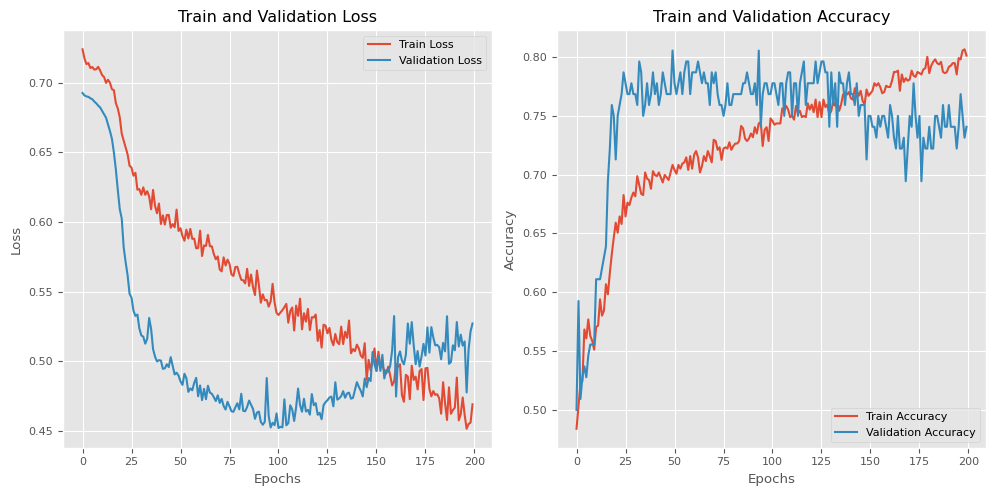

In [ ]:

# model hyperparams
input_size = X_train_tensor[0].shape[1]  # 21+1 dim
hidden_size = 32
num_layers = 2


class AlzSeqLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_prob=0.3):
        super(AlzSeqLSTM, self).__init__()
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Hidden layer
        self.hidden_layer = nn.Linear(hidden_size, hidden_size)  # A hidden layer before FC
        self.relu = nn.ReLU()  # Activation function for the hidden layer

        # Dropout layer
        self.dropout = nn.Dropout(dropout_prob)  # Dropout with a probability of dropout_prob

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size, 2)  # Output layer for binary classification

    def forward(self, x):
        packed_input = rnn_utils.pack_sequence(x, enforce_sorted=False)
        packed_output, (h_n, c_n) = self.lstm(packed_input)
        lstm_out, _ = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)

        # Hidden layer followed by ReLU and Dropout
        hidden_out = self.hidden_layer(h_n[-1])
        hidden_out = self.relu(hidden_out)
        hidden_out = self.dropout(hidden_out)  # Apply dropout after ReLU

        # Fully connected layer
        out = self.fc(hidden_out)
        return out


# init model
model = AlzSeqLSTM(input_size, hidden_size, num_layers)
criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr=0.0001)

# train
num_epochs = 200
batch_size = 32
train_losses = []
eval_losses = []
train_accs = []
train_f1s = []
eval_accs = []
eval_f1s = []

for epoch in range(num_epochs):
  model.train()
  permutation = torch.randperm(len(X_train_tensor))
  epoch_loss = 0.0
  correct_pred = 0
  total_pred = 0

  for i in range(0, len(X_train_tensor), batch_size):
    optimizer.zero_grad()

    batch_indices = permutation[i:i + batch_size]
    batch_X = [X_train_tensor[idx] for idx in batch_indices]
    batch_y = y_train_tensor[batch_indices]

    # feed forward
    outputs = model(batch_X)
    loss = criterion(outputs, batch_y)
    _, predicted = torch.max(outputs, 1)
    total_pred += batch_y.size(0)
    correct_pred += (predicted == batch_y).sum().item()

    # print("Training batch prediction shape:", predicted.shape)
    # print("Training batch label shape:", batch_y.shape)
    # print(predicted)
    # print(batch_y)


    # back prop
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item()

  train_loss = epoch_loss / int(len(X_train_tensor)/batch_size)
  train_losses.append(train_loss)
  train_acc = correct_pred / total_pred
  train_accs.append(train_acc)

  # validation loss
  model.eval()
  with torch.no_grad():
    eval_outputs = model(X_eval_tensor)
    # print(eval_outputs)
    # print(y_eval_tensor)

    eval_loss = criterion(eval_outputs, y_eval_tensor).item()
    _, eval_predicted = torch.max(eval_outputs, 1)

    # print("Validation prediction shape:", eval_predicted.shape)
    # print("Validation label shape:", y_eval_tensor.shape)

    eval_acc = (eval_predicted == y_eval_tensor).sum().item() / len(y_eval_tensor)
    eval_losses.append(eval_loss)
    eval_accs.append(eval_acc)

  print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Eval Loss: {eval_loss:.4f}, Train Acc: {train_acc:.4f}, Eval Acc: {eval_acc:.4f}")

  # Save the model checkpoint
  checkpoint_path = os.path.join(checkpoint_dir, f'epoch_{epoch + 1}.pth')
  torch.save({
      'epoch': epoch + 1,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'train_loss': train_loss,
      'eval_loss': eval_loss,
      'train_acc': train_acc,
      'eval_acc': eval_acc
  }, checkpoint_path)

# train and valid losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(eval_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(eval_accs, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## **Load checkpoints to select best-trained model**

In [1]:
# load a specific model checkpoint
def load_model_checkpoint(checkpoint_path, model, optimizer):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    train_loss = checkpoint['train_loss']
    eval_loss = checkpoint['eval_loss']
    train_acc = checkpoint['train_acc']
    eval_acc = checkpoint['eval_acc']

    print(f"Loaded model from epoch {epoch}: Train Loss = {train_loss:.4f}, Eval Loss = {eval_loss:.4f}, Train Acc = {train_acc:.4f}, Eval Acc = {eval_acc:.4f}")
    return model, optimizer

# change number for best epoch
usedmodel, optimizer = load_model_checkpoint(checkpoint_dir + '/epoch_94.pth', model, optimizer)


NameError: name 'checkpoint_dir' is not defined

Evaluation Accuracy: 0.8056
Confusion Matrix:
[[39 15]
 [ 6 48]]
Precision: 0.7619
Recall: 0.8889
F1 Score: 0.8205


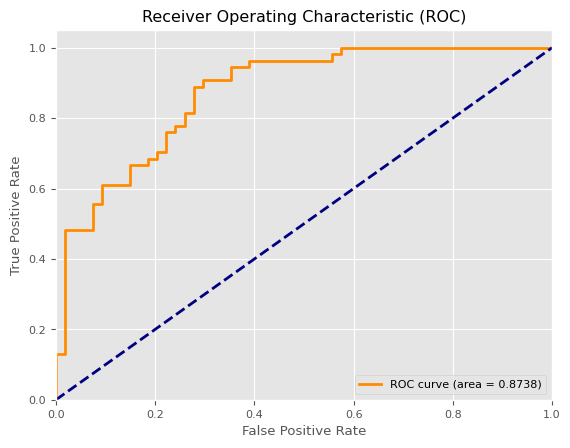

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# evaluate
usedmodel.eval()
with torch.no_grad():
  outputs = usedmodel(X_eval_tensor)
  _, predicted = torch.max(outputs, 1)
  accuracy = (predicted == y_eval_tensor).sum().item() / len(y_eval_tensor)
  print(f"Evaluation Accuracy: {accuracy:.4f}")

  # confusion matrix
  cm = confusion_matrix(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy())
  print(f"Confusion Matrix:\n{cm}")

  # Precision, Recall, F1 Score
  precision = precision_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)
  recall = recall_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)
  f1 = f1_score(y_eval_tensor.cpu().numpy(), predicted.cpu().numpy(), pos_label=1)

  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")

  # ROC and AUC calculation
  y_proba = F.softmax(outputs, dim=1)[:, 1].cpu().numpy()  # probabilities for class 1
  fpr, tpr, _ = roc_curve(y_eval_tensor.cpu().numpy(), y_proba)
  roc_auc = auc(fpr, tpr)

  # Plot ROC curve
  plt.figure()
  plt.rcParams.update({'font.size': 8})

  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC)')
  plt.legend(loc="lower right")
  plt.show()



In [ ]:
np.savez(file_path + 'results_roc_days_'+str(days_keep)+'.npz', fpr=fpr, tpr=tpr, roc_auc=roc_auc)

In [ ]:
import math
num_label_1 = train_df['label'].value_counts().get(1, 0)
print(average_last_test_time)
data_config = {
    "days_keep": days_keep,
    "itemid_set": [all_itemids],
    "set_size": len(all_itemids),
    # "average_time": average_last_test_time,
    # "min_time": min_last_test_time,
    # "q1_time": q1_last_test_time,
    # "median_time": median_last_test_time,
    # "q3_time": q3_last_test_time,
    # "max_time": max_last_test_time,
    "num_ad_patients": num_label_1,
    "accuracy": round(accuracy, 4),
    "precision": round(precision, 4),
    "recall": round(recall, 4),
    "f1": round(f1, 4),
    "roc_auc": round(roc_auc, 4)
}

new_df = pd.DataFrame(data_config)

config_df_path = file_path + 'config_days_df.csv'
if os.path.exists(config_df_path):
    existing_df = pd.read_csv(config_df_path)
    existing_df = existing_df[existing_df['days_keep'] != days_keep]
    updated_df = pd.concat([existing_df, new_df], ignore_index=True)
else:
    updated_df = new_df

updated_df = updated_df.sort_values(by='days_keep')

updated_df.to_csv(config_df_path, index=False)
# updated_df

1068.8821237213833


<ipython-input-38-37a78ab3238e>:2: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



In [ ]:
# print(file_path)


In [ ]:
# torch.save(model.state_dict(), file_path + 'model_pre_blood.pth')


In [ ]:
for i in range(len(df_model_pd)):
  seq = df_model_pd.loc[i, 'itemid_sequence']
  if '52285' in seq:
    print('CSF')
  if '51105' in seq:
    print('Urine')
  # if '50911' in seq:
  #   print('Blood')

## No need to run the following